In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

import copy
import random

import warnings
warnings.filterwarnings("ignore")

In [33]:
class GNN(nn.Module):
    def __init__(self, input_dim, output_dim, task='node', hidden_num = 2, hidden_dim = 32):
        super(GNN, self).__init__()
        self.task = task
        # create the convolution layers
        self.convs = nn.ModuleList()
        self.convs.append(pyg_nn.GCNConv(input_dim, hidden_dim))
        for l in range(hidden_num):
            self.convs.append(pyg_nn.GCNConv(hidden_dim, hidden_dim))

        # create a linear layer
        self.linear = nn.Sequential(nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = hidden_num

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        if data.num_node_features == 0: #if there is no feature, use a constant feature
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, training=self.training)

        if self.task == 'graph': # add pooling mechanism for graph classification
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.linear(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)
            

In [19]:
def get_acc(loader, model, is_validation=False):
    # return the accuracy on a dataset

    correct = 0
    total_acc= 0
    
    model.eval()
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask # get results from the validation of test dataset
            pred = pred[mask]
            label = label[mask]
              
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(mask).item()
    
    total_acc = (correct/total)
    return total_acc

In [20]:
def get_loss(loader, opt, model, is_validation=True):
    # return the accuracy on a dataset

    total_loss = 0
    for data in loader:
        opt.zero_grad()
        embedding, pred = model(data)
        label = data.y
        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask # train on the validation of test dataset
            pred = pred[mask]
            label = label[mask]
        loss = model.loss(pred, label)
        loss.backward()
        opt.step()
        total_loss += loss.item() * data.num_graphs
        
    total_loss /= len(loader.dataset)
    return total_loss

In [21]:
def trainGNN(dataset, task, hidden_num , hidden_dim, lr=0.01):
    trigger = 0
    prev_acc = 0.0
    prev_loss = 1000.0

    if task == 'graph':
        data_size = len(dataset)
        # split data  into traning, validation and testing set
        loader = DataLoader(dataset[:int(data_size * 0.6)], batch_size=64, shuffle=True)
        validation_loader = DataLoader(dataset[int(data_size * 0.6):int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = DataLoader(dataset, batch_size=64, shuffle=True)
        loader = test_loader
        validation_loader = test_loader

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # build model
    model = GNN(max(dataset.num_node_features, 1), dataset.num_classes, task=task, hidden_num=hidden_num, hidden_dim=hidden_dim)
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr)
    
    # train for 200 epochs
    for epoch in range(200):
        training_loss = 0
        validation_loss = 0

        model.train()
        for batch in loader:
            opt.zero_grad()
            # get the prediction and the excpeted label
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            training_loss += loss.item() * batch.num_graphs
            
        training_loss /= len(loader.dataset)

        validation_loss =  get_loss(validation_loader, opt, model)
        validation_acc =  get_acc(validation_loader, model, True)
        
        if validation_acc <= prev_acc:
            trigger += 1

        if trigger >= 10:
            test_acc = get_acc(test_loader, model, False)
            test_loss = get_loss(test_loader, opt, model)
            break
        prev_acc = validation_acc
        
    return model, validation_loss, validation_acc, test_acc, test_loss

# pso functions


In [22]:
class Particle:
    def __init__(self):
        self.hidden_dim = random.randint(2, 50)
        self.hidden_num = random.randint(2, 10)
        self.lr = round(random.uniform(0.0100, 0.0001), 4)
        # self.parameters = NN_parameters()
        self.cognitiveCoef = 1 # can be changed
        self.socialCoef = 1 # can be changed
        self.informantList = list()
        self.informants_best_err = -1
        self.best_err = -1
        self.best_wb = []
        self.informants_best = [self.hidden_num, self.hidden_dim, self.lr]
        self.err = -1  # Current error (set to -1 at start
        self.velocity_hidden_num = random.random()
        self.velocity_hidden_dim = random.random()
        self.velocity_lr = round(random.uniform(0.0100, 0.0001), 4)

    def setInformants(self, swarm, informantNum, index):
        banned_index = []
        i = 0
        swarm_buffer = copy.deepcopy(swarm)
        banned_index.append(index)
        while i < informantNum:
            informant_chosen = np.random.randint(0, len(swarm_buffer))
            if informant_chosen in banned_index:
                continue
            self.informantList.append(swarm[informant_chosen])
            banned_index.append(informant_chosen)
            i += 1

    def set_informant_best(self):
        for informer in self.informantList:
            if informer.best_err < self.informants_best_err or self.informants_best_err == -1:
                self.informants_best_err = informer.best_err
                self.informants_best = informer.best_wb
    
    def check_error(self, loss):
        self.err = 0
        if self.err < self.best_err or self.best_err == -1:
            self.best_err = self.err
            self.best_wb = [self.hidden_num, self.hidden_dim, self.lr]

    def update_velocity(self):
        inertia_weight = 1

        # Change the velocity values for hidden_num
        r1 = random.random()
        r2 = random.random()

        vel_cog = self.cognitiveCoef * r1 * (self.best_wb[0] - self.hidden_num)
        vel_soc = self.socialCoef * r2 * (self.informants_best[0] - self.hidden_num)
        self.velocity_hidden_num = inertia_weight * self.velocity_hidden_num + vel_soc + vel_cog

        #Change the velocity values for hidden_dim
        r1 = random.random()
        r2 = random.random()

        vel_cog = self.cognitiveCoef * r1 * (self.best_wb[1] - self.hidden_dim)
        vel_soc = self.socialCoef * r2 * (self.informants_best[1] - self.hidden_dim)
        self.velocity_hidden_dim = inertia_weight * self.velocity_hidden_dim + vel_soc + vel_cog

        #Change the velocity values for lr
        r1 = random.random()
        r2 = random.random()

        vel_cog = self.cognitiveCoef * r1 * (self.best_wb[2] - self.lr)
        vel_soc = self.socialCoef * r2 * (self.informants_best[2] - self.lr)
        self.velocity_lr = inertia_weight * self.velocity_lr + vel_soc + vel_cog

    # Update the hidden num and dim
    def change_wb(self):
        self.hidden_num = int(round(self.velocity_hidden_num + self.hidden_num))
        self.hidden_dim = int(round(self.velocity_hidden_dim + self.hidden_dim))
        self.lr = self.velocity_lr + self.lr
        # keep the particle coordinate within the boundaries
        if self.hidden_num < 2:
            self.hidden_num = 2
        if self.hidden_num > 10:
            self.hidden_num = 10
        if self.hidden_dim < 2:
            self.hidden_dim = 2
        if self.hidden_dim > 50:
            self.hidden_dim = 50
        if self.lr <= 0:
            self.lr = 0.0001
        elif self.lr > 1:
            self.lr = 1.0000

In [23]:
class Swarm:
    def __init__(self, informants_number, particle_number):
        self.best_loss = 1000
        self.best_accuracy = 0
        self.informants_number = informants_number
        self.swarm = list()
        self.particle_number = particle_number
        self.average_accuracy = 0
        self.average_loss = 0
        self.best_lr = 0
        self.best_hidden_num = 0
        self.best_hidden_dim = 0

        for i in range(self.particle_number):
            new_particle = Particle()
            self.swarm.append(new_particle)
        
        for j in range(len(self.swarm)):
            self.swarm[j].setInformants(self.swarm, self.informants_number, j)
        

    def Optimise(self):
        #Run Optimisation
        for p in range(0,self.particle_number):
            # Find best informants
            self.swarm[p].set_informant_best()
            # Update velocities
            self.swarm[p].update_velocity()
            # Apply velocities the position
            self.swarm[p].change_wb()

    def swarm_iteration(self, dataset, task):
        self.best_test_accuracy = 0
        self.average_test_accuracy = 0
        self.average_test_loss = 0
        for p in range(0, int(self.particle_number)):
            # informants_best[0] = hidden_num
            # informants_best[1] = hidden_dim
            # informants_best[2] = lr

            model, validation_loss, validation_accuracy, test_accuracy, test_loss = trainGNN(dataset, task, int(round(self.swarm[p].hidden_num)),
                                                                                    int(round(self.swarm[p].hidden_dim)), self.swarm[p].lr)
            
            if test_accuracy > self.best_test_accuracy:
                self.best_test_loss = test_loss
                self.best_test_accuracy = test_accuracy
                self.best_lr = self.swarm[p].lr
                self.best_hidden_num = int(round(self.swarm[p].hidden_num))
                self.best_hidden_dim = int(round(self.swarm[p].hidden_dim))

            self.average_test_accuracy += test_accuracy
            self.average_test_loss += test_loss
                
            self.swarm[p].check_error(validation_loss)
        
        self.average_test_accuracy = self.average_test_accuracy / int(self.particle_number)
        self.average_test_loss = self.average_test_loss / int(self.particle_number)
        
        return self.best_test_loss, self.best_test_accuracy, self.average_test_loss, self.average_test_accuracy, self.best_hidden_num, self.best_hidden_dim, self.best_lr

    def get_best(self):
    # Return the best error rate of the entire swarn
        swarm_best_err = -1
        for p in self.swarm:
            if p.best_err < swarm_best_err or swarm_best_err == -1:
                swarm_best_err = p.best_err

        return swarm_best_err

# training the pso algorithm 

In [26]:
# training the pso algorithm

dataset = Planetoid(root='/tmp/cora', name='cora')
dataset = dataset.shuffle()
task = 'node'

data = {'epoch':  [],
        'loss': [],
        'accuracy': [],
        'average_loss': [],
        'average_accuracy': [],
        'best_particle_hidden_num': [],
        'best_particle_hidden_dim': [],
        'best_particle_lr': []
        }

df_cora = pd.DataFrame(data)

# create a swarm with 15 particles with 3 informants
swarm = Swarm(3, 15)
for i in range(100):
    loss, accuracy, average_loss, average_accuracy, best_particle_hidden_num, best_particle_hidden_dim, best_particle_lr = swarm.swarm_iteration(dataset, task)
    print("Epoch = " + str(i) + " ,loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy, 'average_loss':average_loss, 'average_accuracy':average_accuracy,
                'best_particle_hidden_num': best_particle_hidden_num, 'best_particle_hidden_dim': best_particle_hidden_dim, 'best_particle_lr': best_particle_lr}
    df_cora = pd.concat([df_cora, pd.DataFrame([new_row])], ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()


Epoch = 0 ,loss: 0.2586548626422882, accuracy: 0.844
Epoch = 1 ,loss: 0.12245582789182663, accuracy: 0.834
Epoch = 2 ,loss: 0.30349597334861755, accuracy: 0.839
Epoch = 3 ,loss: 0.017986595630645752, accuracy: 0.841
Epoch = 4 ,loss: 0.03212988004088402, accuracy: 0.852
Epoch = 5 ,loss: 0.5776077508926392, accuracy: 0.857
Epoch = 6 ,loss: 0.1004643663764, accuracy: 0.841
Epoch = 7 ,loss: 0.02613481692969799, accuracy: 0.848
Epoch = 8 ,loss: 0.032038625329732895, accuracy: 0.844
Epoch = 9 ,loss: 0.20448125898838043, accuracy: 0.849
Epoch = 10 ,loss: 0.29922837018966675, accuracy: 0.866
Epoch = 11 ,loss: 0.25261974334716797, accuracy: 0.859
Epoch = 12 ,loss: 0.20805536210536957, accuracy: 0.848
Epoch = 13 ,loss: 0.022890711203217506, accuracy: 0.841
Epoch = 14 ,loss: 0.017996784299612045, accuracy: 0.84
Epoch = 15 ,loss: 0.18415243923664093, accuracy: 0.847
Epoch = 16 ,loss: 0.06036322936415672, accuracy: 0.843
Epoch = 17 ,loss: 0.0776507705450058, accuracy: 0.848
Epoch = 18 ,loss: 0.1795

In [27]:
dataset = Planetoid(root='/tmp/pubmed', name='pubmed')
dataset = dataset.shuffle()
task = 'node'

data = {'epoch':  [],
        'loss': [],
        'accuracy': [],
        'average_loss': [],
        'average_accuracy': [],
        'best_particle_hidden_num': [],
        'best_particle_hidden_dim': [],
        'best_particle_lr': []
        }

df_pubmed = pd.DataFrame(data)

# create a swarm with 15 particles with 3 informants
swarm = Swarm(3, 15)
for i in range(100):
    loss, accuracy, average_loss, average_accuracy, best_particle_hidden_num, best_particle_hidden_dim, best_particle_lr = swarm.swarm_iteration(dataset, task)
    print("Epoch = " + str(i) + " ,loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy, 'average_loss':average_loss, 'average_accuracy':average_accuracy,
                'best_particle_hidden_num': best_particle_hidden_num, 'best_particle_hidden_dim': best_particle_hidden_dim, 'best_particle_lr': best_particle_lr}
    df_pubmed = pd.concat([df_pubmed, pd.DataFrame([new_row])], ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()


Epoch = 0 ,loss: 0.16234764456748962, accuracy: 0.829
Epoch = 1 ,loss: 0.22350895404815674, accuracy: 0.829
Epoch = 2 ,loss: 0.17556537687778473, accuracy: 0.828
Epoch = 3 ,loss: 0.28285637497901917, accuracy: 0.833
Epoch = 4 ,loss: 0.33414047956466675, accuracy: 0.816
Epoch = 5 ,loss: 0.08435148000717163, accuracy: 0.833
Epoch = 6 ,loss: 0.2983957529067993, accuracy: 0.829
Epoch = 7 ,loss: 0.15247146785259247, accuracy: 0.842
Epoch = 8 ,loss: 0.3646305799484253, accuracy: 0.827
Epoch = 9 ,loss: 0.1667957603931427, accuracy: 0.838
Epoch = 10 ,loss: 0.2109985053539276, accuracy: 0.839
Epoch = 11 ,loss: 0.899308443069458, accuracy: 0.675
Epoch = 12 ,loss: 0.16628573834896088, accuracy: 0.836
Epoch = 13 ,loss: 0.10141335427761078, accuracy: 0.835
Epoch = 14 ,loss: 0.3869328796863556, accuracy: 0.838
Epoch = 15 ,loss: 0.31807324290275574, accuracy: 0.834
Epoch = 16 ,loss: 0.14405205845832825, accuracy: 0.832
Epoch = 17 ,loss: 0.32062917947769165, accuracy: 0.831
Epoch = 18 ,loss: 0.2672912

In [28]:
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')
dataset = dataset.shuffle()
task = 'graph'

data = {'epoch':  [],
        'loss': [],
        'accuracy': [],
        'average_loss': [],
        'average_accuracy': [],
        'best_particle_hidden_num': [],
        'best_particle_hidden_dim': [],
        'best_particle_lr': []
        }

df_proteins = pd.DataFrame(data)

# create a swarm with 15 particles with 3 informants
swarm = Swarm(3, 15)
for i in range(100):
    loss, accuracy, average_loss, average_accuracy, best_particle_hidden_num, best_particle_hidden_dim, best_particle_lr = swarm.swarm_iteration(dataset, task)
    print("Epoch = " + str(i) + " ,loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy, 'average_loss':average_loss, 'average_accuracy':average_accuracy,
                'best_particle_hidden_num': best_particle_hidden_num, 'best_particle_hidden_dim': best_particle_hidden_dim, 'best_particle_lr': best_particle_lr}
    df_proteins = pd.concat([df_proteins, pd.DataFrame([new_row])], ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()


Processing...
Done!


Epoch = 0 ,loss: 0.6042438724115825, accuracy: 0.7309417040358744
Epoch = 1 ,loss: 0.6234032926003494, accuracy: 0.7354260089686099
Epoch = 2 ,loss: 0.5978881259670172, accuracy: 0.7219730941704036
Epoch = 3 ,loss: 0.6055046579228388, accuracy: 0.7309417040358744
Epoch = 4 ,loss: 0.5930175222623508, accuracy: 0.7309417040358744
Epoch = 5 ,loss: 0.5960472758040835, accuracy: 0.7354260089686099
Epoch = 6 ,loss: 0.6035142404616146, accuracy: 0.7309417040358744
Epoch = 7 ,loss: 0.6063206182467029, accuracy: 0.7130044843049327
Epoch = 8 ,loss: 0.5896260773119905, accuracy: 0.7488789237668162
Epoch = 9 ,loss: 0.589263736132549, accuracy: 0.7309417040358744
Epoch = 10 ,loss: 0.5999675369048867, accuracy: 0.7219730941704036
Epoch = 11 ,loss: 0.6012670726519529, accuracy: 0.7354260089686099
Epoch = 12 ,loss: 0.6031297458661511, accuracy: 0.7354260089686099
Epoch = 13 ,loss: 0.589708543144534, accuracy: 0.7354260089686099
Epoch = 14 ,loss: 0.6034879350341489, accuracy: 0.7399103139013453
Epoch =

In [29]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
task = 'graph'

data = {'epoch':  [],
        'loss': [],
        'accuracy': [],
        'average_loss': [],
        'average_accuracy': [],
        'best_particle_hidden_num': [],
        'best_particle_hidden_dim': [],
        'best_particle_lr': []
        }
df_enzymes = pd.DataFrame(data)

# create a swarm with 15 particles with 3 informants
swarm = Swarm(3, 15)
for i in range(100):
    loss, accuracy, average_loss, average_accuracy, best_particle_hidden_num, best_particle_hidden_dim, best_particle_lr = swarm.swarm_iteration(dataset, task)
    print("Epoch = " + str(i) + " ,loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy, 'average_loss':average_loss, 'average_accuracy':average_accuracy,
                'best_particle_hidden_num': best_particle_hidden_num, 'best_particle_hidden_dim': best_particle_hidden_dim, 'best_particle_lr': best_particle_lr}
    df_enzymes = pd.concat([df_enzymes, pd.DataFrame([new_row])], ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()


Epoch = 0 ,loss: 1.6815439860026042, accuracy: 0.31666666666666665
Epoch = 1 ,loss: 1.686219541231791, accuracy: 0.3
Epoch = 2 ,loss: 1.7064592440923054, accuracy: 0.2916666666666667
Epoch = 3 ,loss: 1.7015562454859416, accuracy: 0.3333333333333333
Epoch = 4 ,loss: 1.7123281240463257, accuracy: 0.2833333333333333
Epoch = 5 ,loss: 1.7042592843373616, accuracy: 0.30833333333333335
Epoch = 6 ,loss: 1.7269456148147584, accuracy: 0.3
Epoch = 7 ,loss: 1.6669078747431436, accuracy: 0.3416666666666667
Epoch = 8 ,loss: 1.69273153146108, accuracy: 0.3333333333333333
Epoch = 9 ,loss: 1.6888829708099364, accuracy: 0.325
Epoch = 10 ,loss: 1.6933104912439982, accuracy: 0.325
Epoch = 11 ,loss: 1.7104323546091715, accuracy: 0.2916666666666667
Epoch = 12 ,loss: 1.6909492254257201, accuracy: 0.30833333333333335
Epoch = 13 ,loss: 1.6910919984181723, accuracy: 0.31666666666666665
Epoch = 14 ,loss: 1.692190909385681, accuracy: 0.31666666666666665
Epoch = 15 ,loss: 1.6729095300038657, accuracy: 0.2833333333

 # результаты

In [30]:
all_time_best_accuracy_cora = list()
all_time_best_loss_cora = list()
all_time_best_accuracy_pubmed = list()
all_time_best_loss_pubmed = list()
all_time_best_accuracy_proteins = list()
all_time_best_loss_proteins = list()
all_time_best_accuracy_enzymes = list()
all_time_best_loss_enzymes = list()
tmp_best_accuracy = 0.0
tmp_best_loss = 1000.0

for index, row in df_cora.iterrows():
    if float(row['accuracy']) > tmp_best_accuracy:
        tmp_best_accuracy = float(row['accuracy'])
    if float(row['loss']) < tmp_best_loss:
        tmp_best_loss = float(row['loss'])
    all_time_best_accuracy_cora.append(tmp_best_accuracy)
    all_time_best_loss_cora.append(tmp_best_loss)

tmp_best_accuracy = 0.0
tmp_best_loss = 1000.0

for index, row in df_pubmed.iterrows():
    if float(row['accuracy']) > tmp_best_accuracy:
        tmp_best_accuracy = float(row['accuracy'])
    if float(row['loss']) < tmp_best_loss:
        tmp_best_loss = float(row['loss'])
    all_time_best_accuracy_pubmed.append(tmp_best_accuracy)
    all_time_best_loss_pubmed.append(tmp_best_loss)

tmp_best_accuracy = 0.0

for index, row in df_proteins.iterrows():
    if float(row['accuracy']) > tmp_best_accuracy:
        tmp_best_accuracy = float(row['accuracy'])
    if float(row['loss']) < tmp_best_loss:
        tmp_best_loss = float(row['loss'])
    all_time_best_accuracy_proteins.append(tmp_best_accuracy)
    all_time_best_loss_proteins.append(tmp_best_loss)

tmp_best_accuracy = 0.0
tmp_best_loss = 1000.0

for index, row in df_enzymes.iterrows():
    if float(row['accuracy']) > tmp_best_accuracy:
        tmp_best_accuracy = float(row['accuracy'])
    if float(row['loss']) < tmp_best_loss:
        tmp_best_loss = float(row['loss'])
    all_time_best_accuracy_enzymes.append(tmp_best_accuracy)
    all_time_best_loss_enzymes.append(tmp_best_loss)

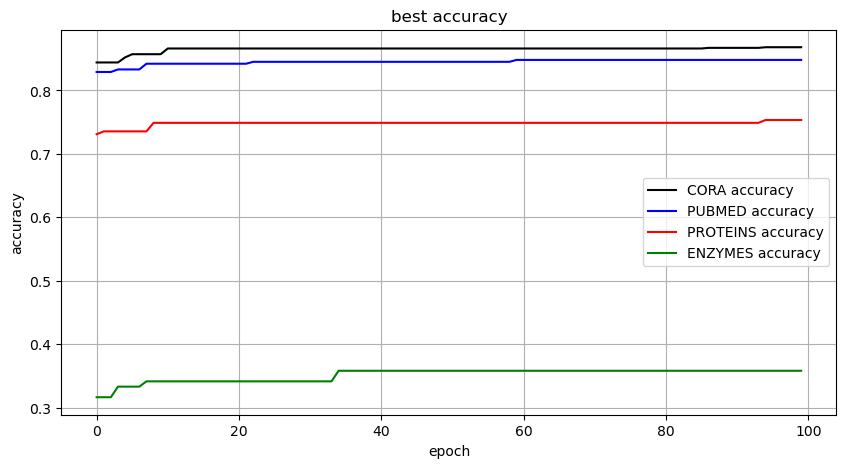

In [48]:
plt.plot(df_cora['epoch'], all_time_best_accuracy_cora, label = "CORA accuracy", color="black")
plt.plot(df_pubmed['epoch'], all_time_best_accuracy_pubmed, label = "PUBMED accuracy", color="blue")
plt.plot(df_proteins['epoch'], all_time_best_accuracy_proteins, label = "PROTEINS accuracy", color="red")
plt.plot(df_enzymes['epoch'], all_time_best_accuracy_enzymes, label = "ENZYMES accuracy", color="green")
# plt.plot(df_cora['epoch'], all_time_best_loss, label = "loss", color="red")
plt.title('best accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

In [1]:
plt.plot(df_cora['epoch'], all_time_best_loss_cora, label = "CORA loss", color="black")
plt.plot(df_cora['epoch'], all_time_best_loss_pubmed, label = "PUBMED loss", color="blue")
plt.plot(df_proteins['epoch'], all_time_best_loss_proteins, label = "PROTEINS loss", color="red")
plt.plot(df_enzymes['epoch'], all_time_best_loss_enzymes, label = "ENZYMES loss", color="green")
# plt.plot(df_cora['epoch'], all_time_best_loss, label = "loss", color="red")
plt.title('best loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

NameError: name 'plt' is not defined

In [36]:
all_time_best_average_accuracy_cora = list()
all_time_best_average_loss_cora = list()
all_time_best_average_accuracy_pubmed = list()
all_time_best_average_loss_pubmed = list()
all_time_best_average_accuracy_proteins = list()
all_time_best_average_loss_proteins = list()
all_time_best_average_accuracy_enzymes = list()
all_time_best_average_loss_enzymes = list()
tmp_best_average_accuracy = 0.0
tmp_best_average_loss = 1000.0

for index, row in df_cora.iterrows():
    if float(row['average_accuracy']) > tmp_best_average_accuracy:
        tmp_best_average_accuracy = float(row['average_accuracy'])
    if float(row['average_loss']) < tmp_best_average_loss:
        tmp_best_average_loss = float(row['average_loss'])
    all_time_best_average_accuracy_cora.append(tmp_best_average_accuracy)
    all_time_best_average_loss_cora.append(tmp_best_average_loss)

tmp_best_average_accuracy = 0.0
tmp_best_average_loss = 1000.0

for index, row in df_pubmed.iterrows():
    if float(row['average_accuracy']) > tmp_best_average_accuracy:
        tmp_best_average_accuracy = float(row['average_accuracy'])
    if float(row['average_loss']) < tmp_best_average_loss:
        tmp_best_average_loss = float(row['average_loss'])
    all_time_best_average_accuracy_pubmed.append(tmp_best_average_accuracy)
    all_time_best_average_loss_pubmed.append(tmp_best_average_loss)

tmp_best_average_accuracy = 0.0

for index, row in df_proteins.iterrows():
    if float(row['average_accuracy']) > tmp_best_average_accuracy:
        tmp_best_average_accuracy = float(row['average_accuracy'])
    if float(row['average_loss']) < tmp_best_average_loss:
        tmp_best_average_loss = float(row['average_loss'])
    all_time_best_average_accuracy_proteins.append(tmp_best_average_accuracy)
    all_time_best_average_loss_proteins.append(tmp_best_average_loss)

tmp_best_average_accuracy = 0.0
tmp_best_average_loss = 1000.0

for index, row in df_enzymes.iterrows():
    if float(row['average_accuracy']) > tmp_best_average_accuracy:
        tmp_best_average_accuracy = float(row['average_accuracy'])
    if float(row['average_loss']) < tmp_best_average_loss:
        tmp_best_average_loss = float(row['average_loss'])
    all_time_best_average_accuracy_enzymes.append(tmp_best_average_accuracy)
    all_time_best_average_loss_enzymes.append(tmp_best_average_loss)

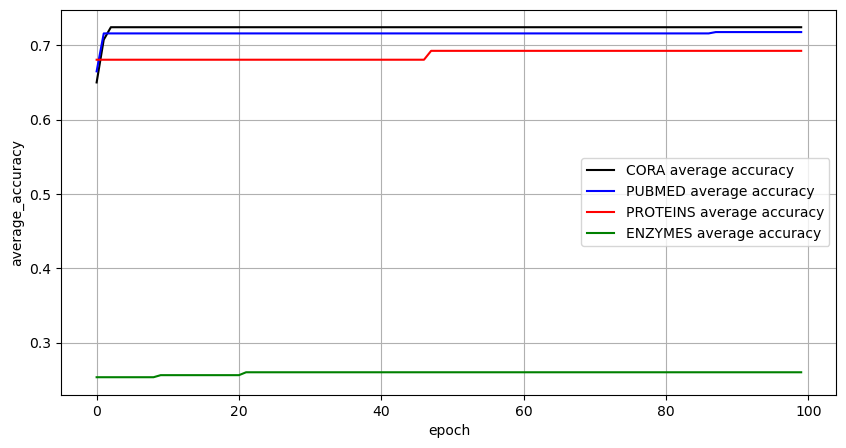

In [53]:
plt.plot(df_cora['epoch'], all_time_best_average_accuracy_cora, label = "CORA average accuracy", color="black")
plt.plot(df_pubmed['epoch'], all_time_best_average_accuracy_pubmed, label = "PUBMED average accuracy", color="blue")
plt.plot(df_proteins['epoch'], all_time_best_average_accuracy_proteins, label = "PROTEINS average accuracy", color="red")
plt.plot(df_enzymes['epoch'], all_time_best_average_accuracy_enzymes, label = "ENZYMES average accuracy", color="green")
# plt.title('best average_accuracy')
plt.xlabel('epoch')
plt.ylabel('average_accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

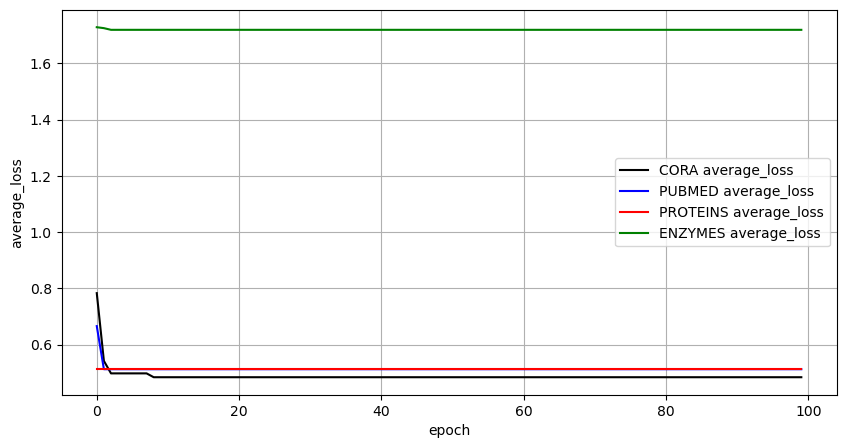

In [54]:
plt.plot(df_cora['epoch'], all_time_best_average_loss_cora, label = "CORA average_loss", color="black")
plt.plot(df_pubmed['epoch'], all_time_best_average_loss_pubmed, label = "PUBMED average_loss", color="blue")
plt.plot(df_proteins['epoch'], all_time_best_average_loss_proteins, label = "PROTEINS average_loss", color="red")
plt.plot(df_enzymes['epoch'], all_time_best_average_loss_enzymes, label = "ENZYMES average_loss", color="green")
# plt.title('best average_loss')
plt.xlabel('epoch')
plt.ylabel('average_loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

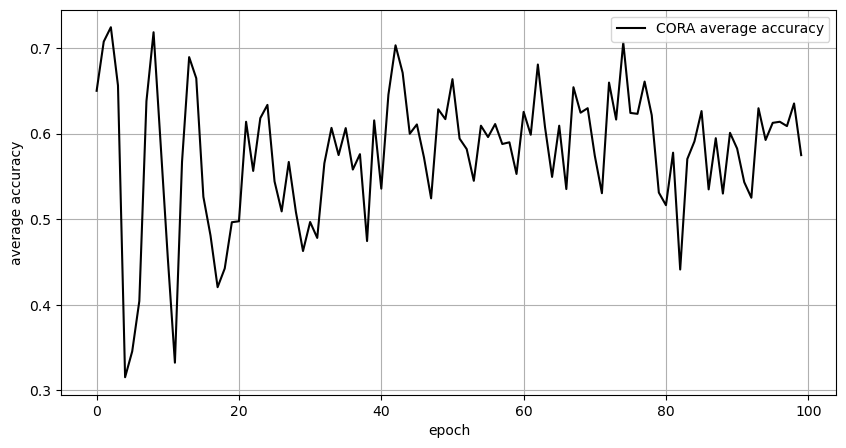

In [55]:
plt.plot(df_cora['epoch'], df_cora["average_accuracy"], label = "CORA average accuracy", color="black")
# plt.title('evolution of average accuracy')
plt.xlabel('epoch')
plt.ylabel('average accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

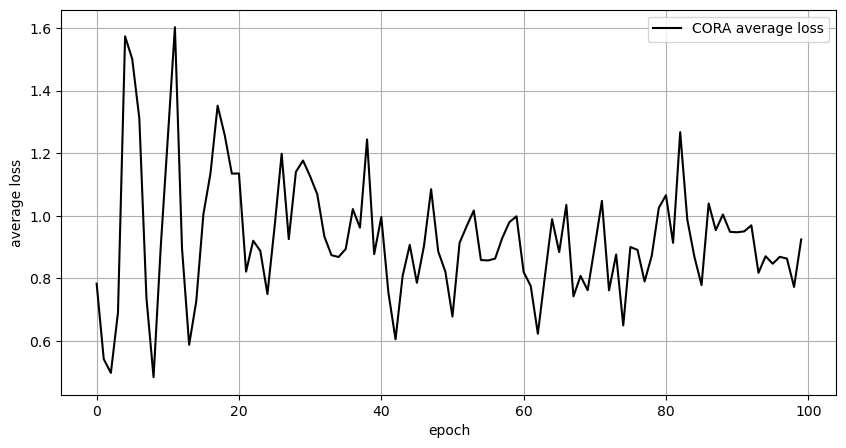

In [56]:
plt.plot(df_cora['epoch'], df_cora["average_loss"], label = "CORA average loss", color="black")
# plt.title('evolution of average loss')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

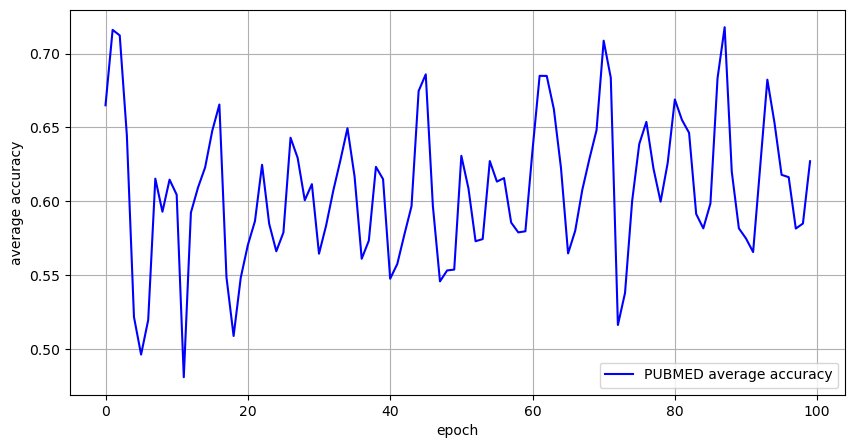

In [57]:
plt.plot(df_pubmed['epoch'], df_pubmed["average_accuracy"], label = "PUBMED average accuracy", color="blue")
# plt.title('evolution of average accuracy')
plt.xlabel('epoch')
plt.ylabel('average accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

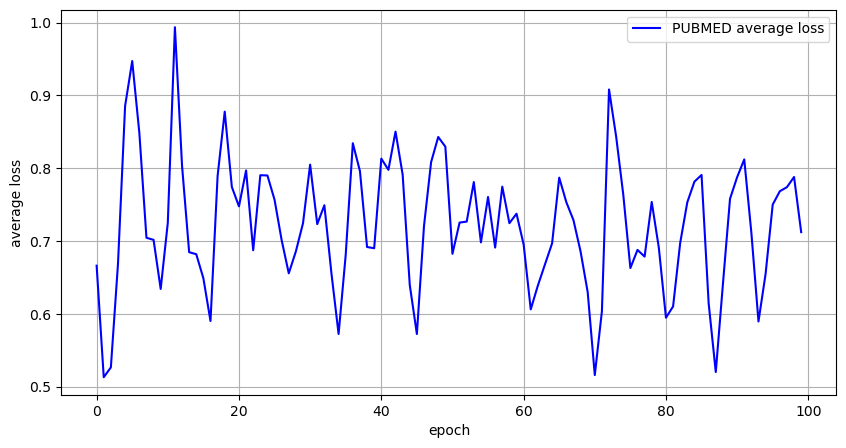

In [58]:
plt.plot(df_pubmed['epoch'], df_pubmed["average_loss"], label = "PUBMED average loss", color="blue")
# plt.title('evolution of average loss')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

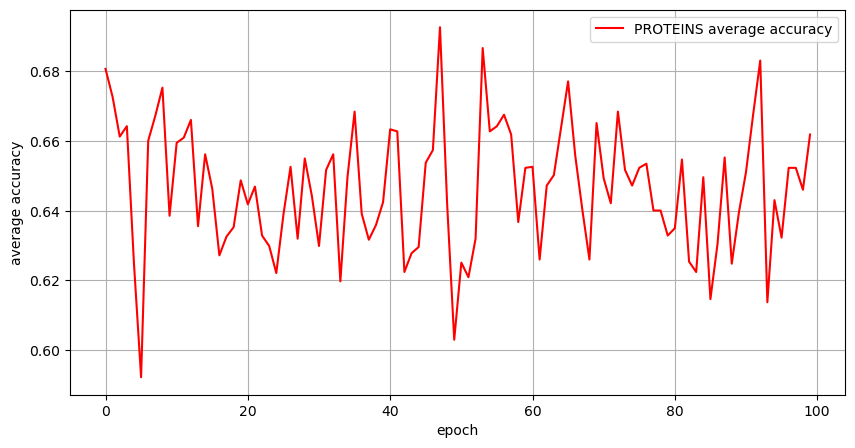

In [59]:
plt.plot(df_proteins['epoch'], df_proteins["average_accuracy"], label = "PROTEINS average accuracy", color="red")
# plt.title('evolution of average accuracy')
plt.xlabel('epoch')
plt.ylabel('average accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

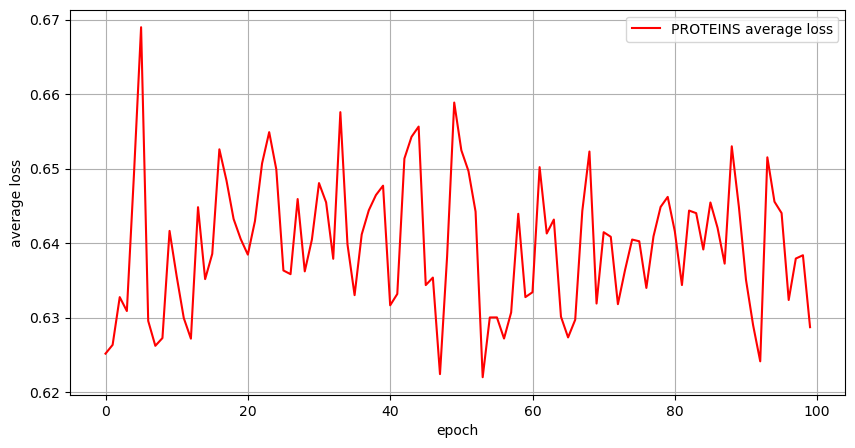

In [60]:
plt.plot(df_proteins['epoch'], df_proteins["average_loss"], label = "PROTEINS average loss", color="red")
# plt.title('evolution of average loss')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

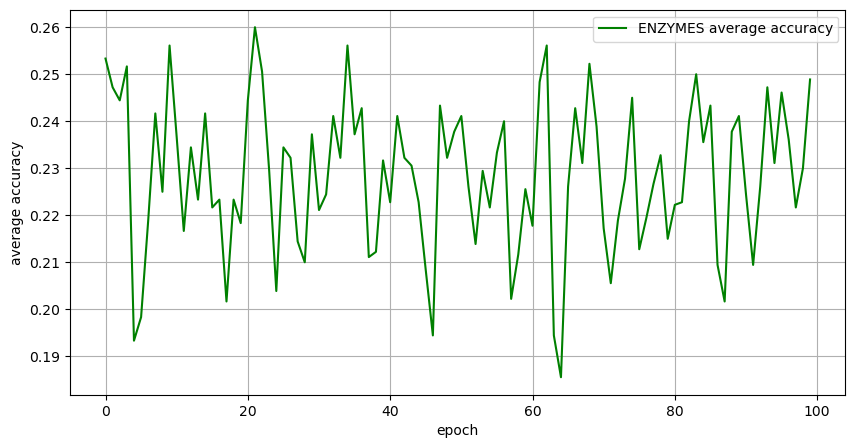

In [61]:
plt.plot(df_enzymes['epoch'], df_enzymes["average_accuracy"], label = "ENZYMES average accuracy", color="green")
# plt.title('evolution of average accuracy')
plt.xlabel('epoch')
plt.ylabel('average accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

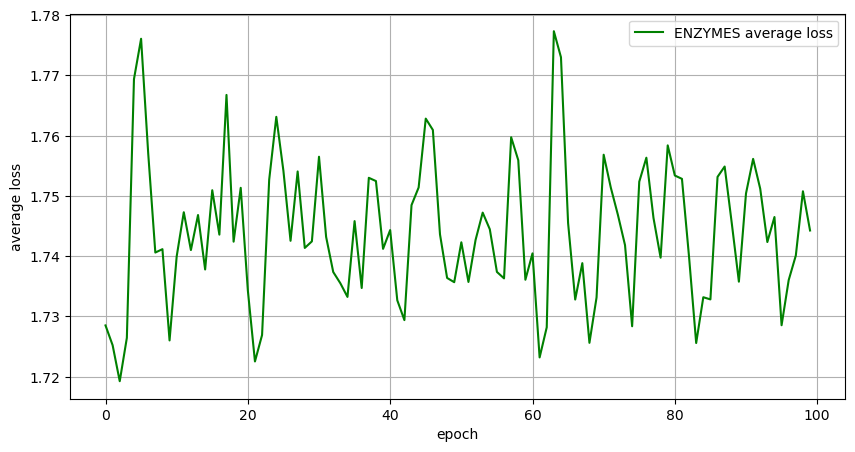

In [62]:
	
plt.plot(df_enzymes['epoch'], df_enzymes["average_loss"], label = "ENZYMES average loss", color="green")
# plt.title('evolution of average loss')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

In [47]:
df_enzymes.to_csv('enzymes.csv')
df_proteins.to_csv('proteins.csv')
df_pubmed.to_csv('pubmed.csv')
df_cora.to_csv('cora.csv')